# libraries


In [1]:
! pip install pyod
! pip install dash
! pip install dash_bootstrap_components
from IPython.display import clear_output
clear_output()

In [2]:
#import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, levene, shapiro
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from sklearn.preprocessing import StandardScaler

# EDA

In [3]:
#Data Connection
Demand = pd.read_excel('/content/drive/MyDrive/carerha sessions/Data/Final Project/Demand.xlsx')
sites_energy_consumption_1 = pd.read_csv('/content/drive/MyDrive/carerha sessions/Data/Final Project/Sites Energy Consumption Part_001.csv')
sites_energy_consumption_2 = pd.read_csv('/content/drive/MyDrive/carerha sessions/Data/Final Project/Sites Energy Consumption Part_002.csv')
sites_energy_consumption_3 = pd.read_csv('/content/drive/MyDrive/carerha sessions/Data/Final Project/Sites Energy Consumption Part_003.csv')

In [4]:
#lets see patrens of data
print(Demand.info())
print(sites_energy_consumption_1.info())
print(sites_energy_consumption_2.info())
print(sites_energy_consumption_3.info())
print("\n")
print(Demand.head())
print(sites_energy_consumption_1.head())
print(sites_energy_consumption_2.head())
print(sites_energy_consumption_3.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DemandDateTime  17520 non-null  datetime64[ns]
 1   Demand          17520 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 273.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484387 entries, 0 to 484386
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   cell_id                  484387 non-null  object 
 1   DateTime                 484387 non-null  object 
 2   KWH/hh (per half hour)   484387 non-null  float64
 3   site_id                  484387 non-null  object 
 4   region                   484387 non-null  object 
dtypes: float64(1), object(4)
memory usage: 18.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444898 entries,

firt insight :
  - no missing data
  - need to transform date col. from object to datetime

In [5]:
#concatenate sites_energy_consumption data frams in one
sites_energy_consumption = pd.concat([sites_energy_consumption_1,sites_energy_consumption_2,sites_energy_consumption_3],ignore_index=True)

#trasform datetime type
sites_energy_consumption['DateTime'] = pd.to_datetime(sites_energy_consumption['DateTime'], format='%H:%M:%S %y,%d,%m')


#rename KWH/hh (per half hour) to Energy consumed
sites_energy_consumption.rename(columns={'KWH/hh (per half hour) ':'Energy_consumed_per_half_hour'}, inplace=True)

#check
print(sites_energy_consumption.info())
print(sites_energy_consumption.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 5 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   cell_id                        1380252 non-null  object        
 1   DateTime                       1380252 non-null  datetime64[ns]
 2   Energy_consumed_per_half_hour  1380252 non-null  float64       
 3   site_id                        1380252 non-null  object        
 4   region                         1380252 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 52.7+ MB
None
     cell_id            DateTime  Energy_consumed_per_half_hour site_id region
0  MAC000002 2013-01-01 00:00:00                          0.219       A      A
1  MAC000002 2013-01-01 00:30:00                          0.241       A      A
2  MAC000002 2013-01-01 01:00:00                          0.191       A      A
3  MAC000002

In [6]:
# merge btween sites_energy_consumption and Demand
df = pd.merge(sites_energy_consumption,Demand,  left_on='DateTime', right_on='DemandDateTime', how='inner')

#drop DemandDateTime col.
df.drop('DemandDateTime', axis=1, inplace=True)

#check
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 6 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   cell_id                        1380252 non-null  object        
 1   DateTime                       1380252 non-null  datetime64[ns]
 2   Energy_consumed_per_half_hour  1380252 non-null  float64       
 3   site_id                        1380252 non-null  object        
 4   region                         1380252 non-null  object        
 5   Demand                         1380252 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 63.2+ MB
None
     cell_id            DateTime  Energy_consumed_per_half_hour site_id  \
0  MAC000002 2013-01-01 00:00:00                          0.219       A   
1  MAC000002 2013-01-01 00:30:00                          0.241       A   
2  MAC000002 2013-01-01 01:00:00  

In [7]:
#check dublicates
print(df.duplicated().sum())

942


In [8]:
#remove dublicate rows
df.drop_duplicates(inplace=True)

#check
df.duplicated().sum()

0

from the diffrance between mean to max : there are outlires

In [9]:
#describ tha data
print((df[['Energy_consumed_per_half_hour']].describe()).round(2))

       Energy_consumed_per_half_hour
count                     1379310.00
mean                            0.24
std                             6.77
min                             0.00
25%                             0.06
50%                             0.14
75%                             0.26
max                          7657.00


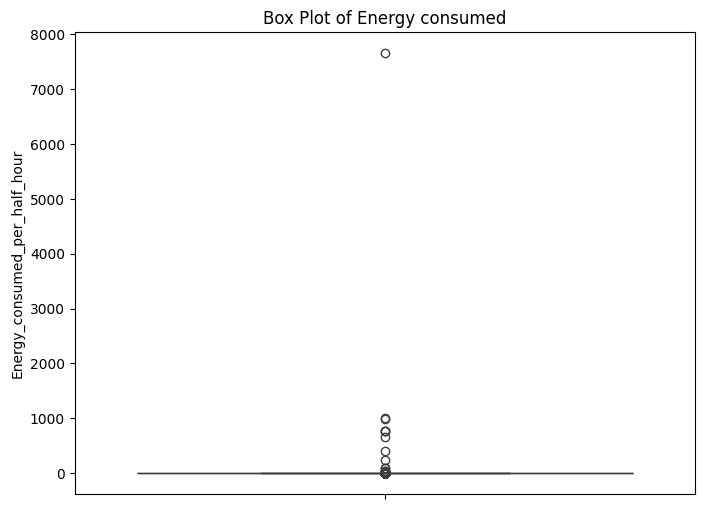

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(df['Energy_consumed_per_half_hour'])
plt.title('Box Plot of Energy consumed')
plt.show()

In [11]:
# Normalize The Values in the needed features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[['Energy_consumed_per_half_hour']])
# detect anomaly data by three methods
# KNN
knn_detector = KNN()
knn_detector.fit(features_scaled)
df['AD_KNN'] = knn_detector.labels_

# IForest
iforest_detector = IForest()
iforest_detector.fit(features_scaled)
df['AD_IForest'] = iforest_detector.labels_

# LOF
LOF_detector = LOF()
LOF_detector.fit(features_scaled)
df['AD_LOF'] = LOF_detector.labels_

# check
print(df.head())

     cell_id            DateTime  Energy_consumed_per_half_hour site_id  \
0  MAC000002 2013-01-01 00:00:00                          0.219       A   
1  MAC000002 2013-01-01 00:30:00                          0.241       A   
2  MAC000002 2013-01-01 01:00:00                          0.191       A   
3  MAC000002 2013-01-01 01:30:00                          0.235       A   
4  MAC000002 2013-01-01 02:00:00                          0.182       A   

  region  Demand  AD_KNN  AD_IForest  AD_LOF  
0      A  Normal       0           0       0  
1      A  Normal       0           0       0  
2      A  Normal       0           0       0  
3      A  Normal       0           0       0  
4      A  Normal       0           0       0  


In [12]:
# Imputation in case the 3 methods dectect that it anomaly
df['Energy_consumed_per_half_hour'] = np.where(((df['AD_LOF'] == 1) & (df['AD_IForest']==1) & (df['AD_KNN']==1)), np.median(df['Energy_consumed_per_half_hour']), df['Energy_consumed_per_half_hour'])

# check
print(df['Energy_consumed_per_half_hour'].describe().round(2))

count    1379310.00
mean           0.23
std            0.30
min            0.00
25%            0.06
50%            0.14
75%            0.26
max            5.78
Name: Energy_consumed_per_half_hour, dtype: float64


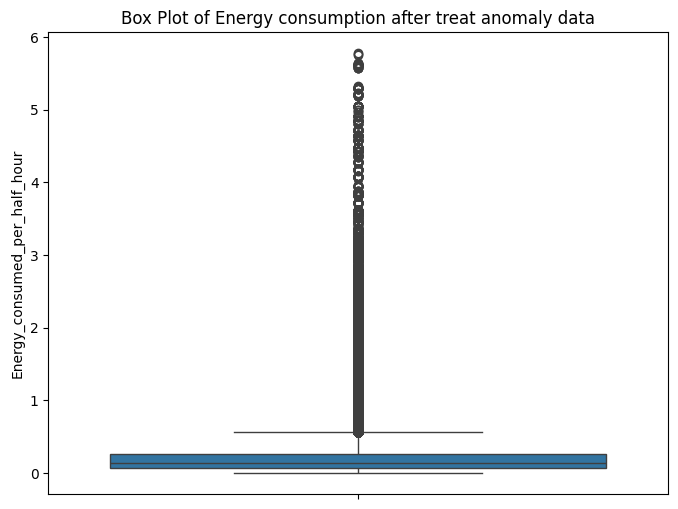

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(df['Energy_consumed_per_half_hour'])
plt.title('Box Plot of Energy consumption after treat anomaly data')
plt.show()

Demand prices for calculating cost:
------
- High (77.21p/kWh)
- Normal (19.46p/kWh)
- Low (6.89p/kWh)

In [14]:
#identify unique values in demand
df['Demand'].unique()

array(['Normal', 'Low', 'Normall', 'High', 'normal', 'high'], dtype=object)

In [15]:
demand_values = {
    'normal': 'Normal',
    'Normall': 'Normal',
    'high': 'High',
}

# Replace values in the 'Demand' column
df.replace({'Demand':demand_values}, inplace=True)
df['Demand'].unique()

array(['Normal', 'Low', 'High'], dtype=object)

In [16]:
# Define demand prices in pounds(EGP) per kWh
demand_prices = {
    'High': 0.7721,
    'Normal': 0.1946,
    'Low': 0.0689
}

# Calculate the cost of Energy_consumed_per_half_hour
df['Cost_per_half_hour'] = df['Energy_consumed_per_half_hour'] * df['Demand'].map(demand_prices)

# Display the updated DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1379310 entries, 0 to 1380251
Data columns (total 10 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   cell_id                        1379310 non-null  object        
 1   DateTime                       1379310 non-null  datetime64[ns]
 2   Energy_consumed_per_half_hour  1379310 non-null  float64       
 3   site_id                        1379310 non-null  object        
 4   region                         1379310 non-null  object        
 5   Demand                         1379310 non-null  object        
 6   AD_KNN                         1379310 non-null  int64         
 7   AD_IForest                     1379310 non-null  int64         
 8   AD_LOF                         1379310 non-null  int64         
 9   Cost_per_half_hour             1379310 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memor

In [17]:
#describ tha data
print((df[['Energy_consumed_per_half_hour','Cost_per_half_hour']].describe()).round(2))

       Energy_consumed_per_half_hour  Cost_per_half_hour
count                     1379310.00          1379310.00
mean                            0.23                0.05
std                             0.30                0.08
min                             0.00                0.00
25%                             0.06                0.01
50%                             0.14                0.03
75%                             0.26                0.05
max                             5.78                3.63


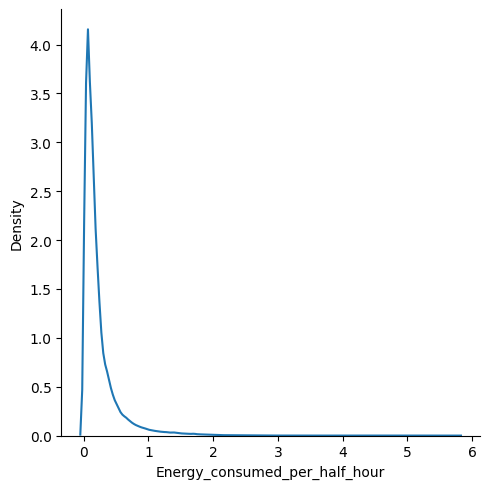

In [19]:
#show the dist.
sns.displot(df, x="Energy_consumed_per_half_hour", kind="kde")

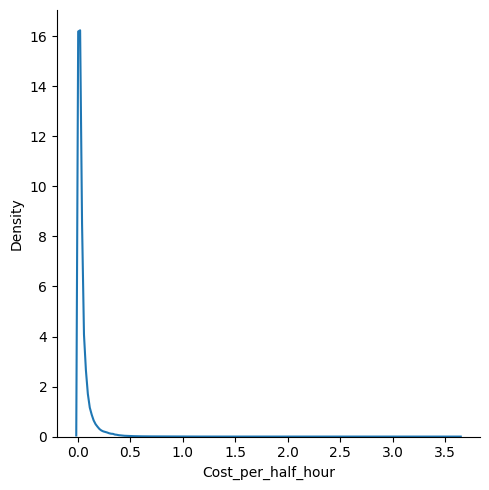

In [ ]:
#show the dist.
sns.displot(df, x="Cost_per_half_hour", kind="kde")

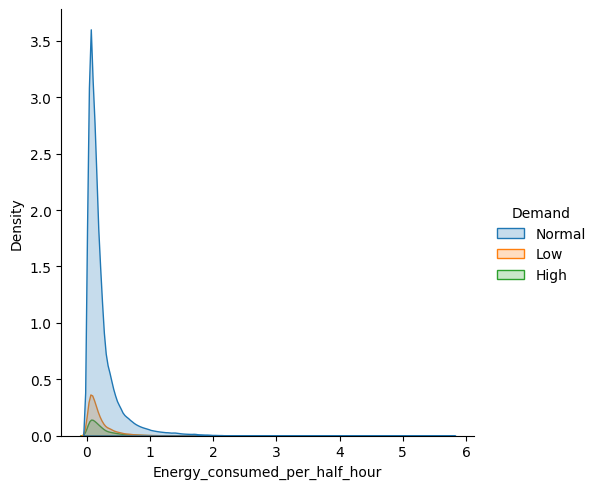

In [21]:
sns.displot(df, x="Energy_consumed_per_half_hour", hue="Demand", kind="kde", fill=True)

<Axes: xlabel='DateTime', ylabel='Energy_consumed_per_half_hour'>

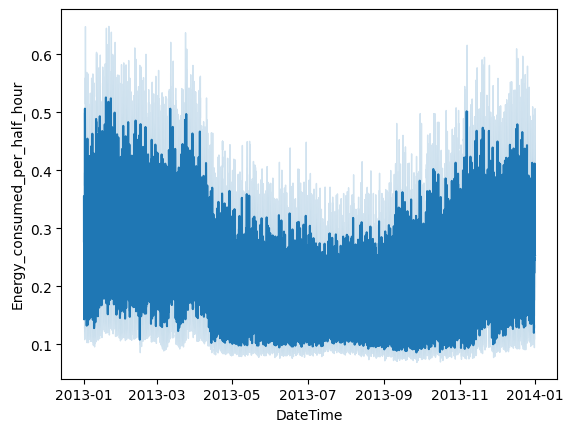

In [ ]:
# visiualize Energy consumption During the Year
sns.lineplot(data=df, x='DateTime', y='Energy_consumed_per_half_hour')

Energy Consumption is Low from May to September

In [ ]:
region_consumption = df.groupby('region')['Energy_consumed_per_half_hour'].sum()
regions = region_consumption.index
consumption_values = region_consumption.values


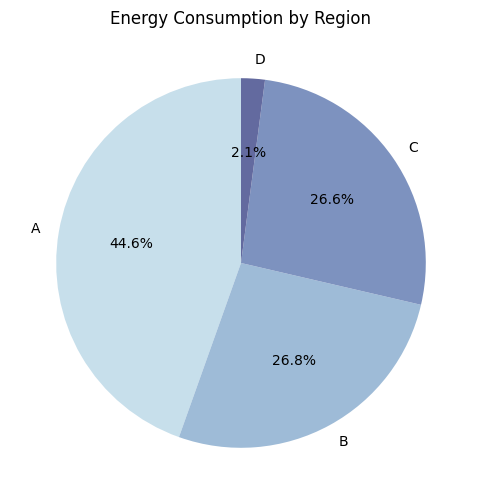

In [ ]:
# most region consumes enrgy
plt.figure(figsize=(8, 6))
plt.pie(consumption_values, labels=regions, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("ch:s=.25,rot=-.25"))
plt.title('Energy Consumption by Region')
plt.show()

region A is the most region that consumes the most energy

<ipython-input-120-ab09824275cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_a_data['hour'] = region_a_data['DateTime'].dt.hour


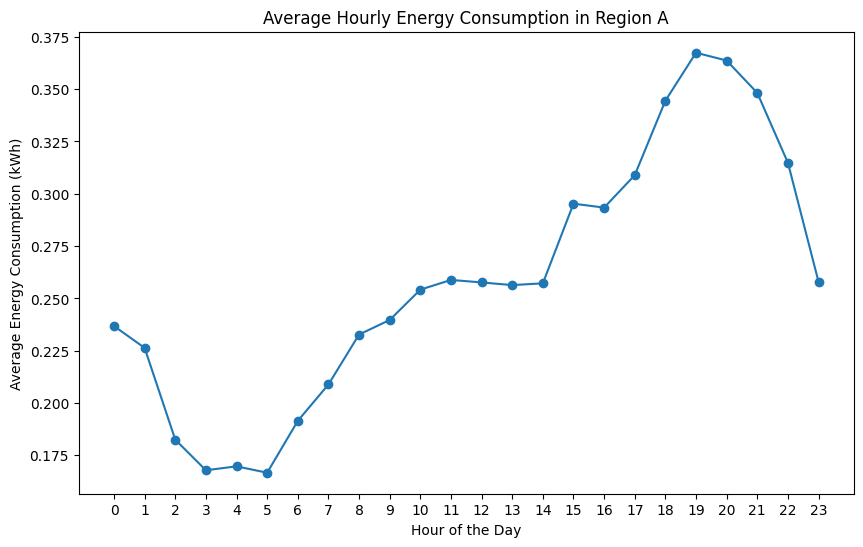

In [ ]:
# visialize energy consumption in region A
region_a_data = df[df['region'] == 'A']
region_a_data['hour'] = region_a_data['DateTime'].dt.hour
hourly_consumption = region_a_data.groupby('hour')['Energy_consumed_per_half_hour'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_consumption.index, hourly_consumption.values, marker='o', linestyle='-')
plt.title('Average Hourly Energy Consumption in Region A')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption (kWh)')
plt.xticks(np.arange(0, 24, 1))
plt.show()

<ipython-input-121-a89c8722c921>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_a_data['hour'] = region_a_data['DateTime'].dt.hour


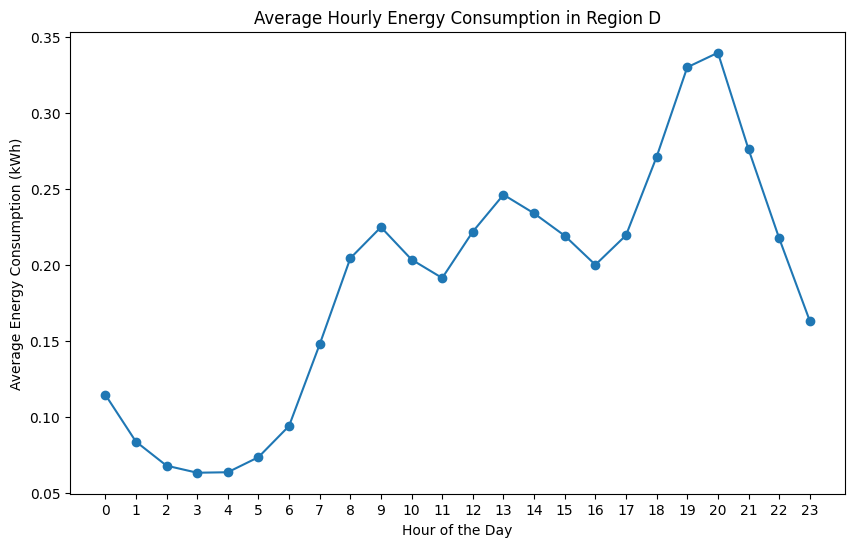

In [ ]:
# visialize energy consumption in region D
region_a_data = df[df['region'] == 'D']
region_a_data['hour'] = region_a_data['DateTime'].dt.hour
hourly_consumption = region_a_data.groupby('hour')['Energy_consumed_per_half_hour'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_consumption.index, hourly_consumption.values, marker='o', linestyle='-')
plt.title('Average Hourly Energy Consumption in Region D')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption (kWh)')
plt.xticks(np.arange(0, 24, 1))
plt.show()

# Does the region significantly affect energy consumption?
___________

- H0 : The mean energy consumption is the same across all regions (𝜇𝐴=𝜇𝐵=𝜇𝐶=𝜇𝐷 ).

- Ha : At least one region has a significantly different mean energy consumption.

In [ ]:
# Group data by region
grouped = df.groupby('region')['Energy_consumed_per_half_hour']

# Perform ANOVA
stat, p = f_oneway(*[values for _, values in grouped])
print(f"ANOVA F-statistic = {stat}, p-value = {p}")

ANOVA F-statistic = 4319.352390493765, p-value = 0.0


Conclusion:
- p-value is less than 0.05 which mean that we reject the null hypothesis, indicating that the region significantly affects energy consumption.

In [22]:
# Post-hoc analysis for identify which specific regions differ.
tukey = pairwise_tukeyhsd(endog=df['Energy_consumed_per_half_hour'], groups=df['region'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     A      B  -0.0662   0.0 -0.0677 -0.0647   True
     A      C  -0.0298   0.0 -0.0314 -0.0282   True
     A      D   -0.072   0.0 -0.0762 -0.0679   True
     B      C   0.0364   0.0  0.0347  0.0381   True
     B      D  -0.0058 0.002   -0.01 -0.0017   True
     C      D  -0.0422   0.0 -0.0465  -0.038   True
---------------------------------------------------


Conclusion:
- The region significantly affect energy consumption since all comparisons are significant.


# Is there a relationship between the time of day and energy consumption?
_____________
- H0 : There is no significant difference in energy consumption across different times of the day.
- H1 : There is a significant difference in energy consumption across different times of the day.

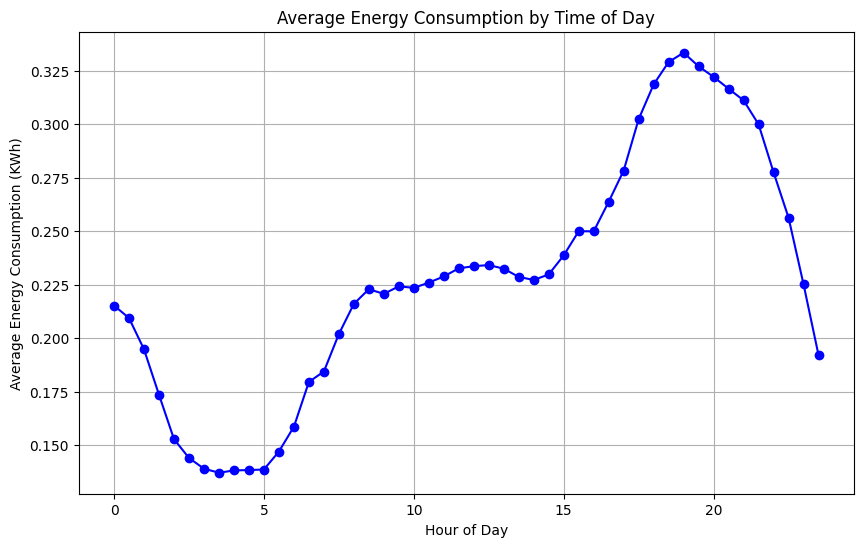

In [26]:
# visiualize Energy consumption during day
# Assuming df is the DataFrame containing energy consumption data
# Get hour in decimal form
df['hour'] = df['DateTime'].dt.hour + df['DateTime'].dt.minute / 60

# Group by the hour and calculate mean energy consumption
avg_energy_by_hour = df.groupby('hour')['Energy_consumed_per_half_hour'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(avg_energy_by_hour.index, avg_energy_by_hour.values, marker='o', linestyle='-', color='b')
plt.title('Average Energy Consumption by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption (KWh)')
plt.grid(True)
plt.show()

the most consumption time from 3 PM TO 11 PM

In [ ]:
correlation = df['hour'].corr(df['Energy_consumed_per_half_hour'])
print(f'Pearson Correlation: {correlation}')

Pearson Correlation: 0.1533984167634082


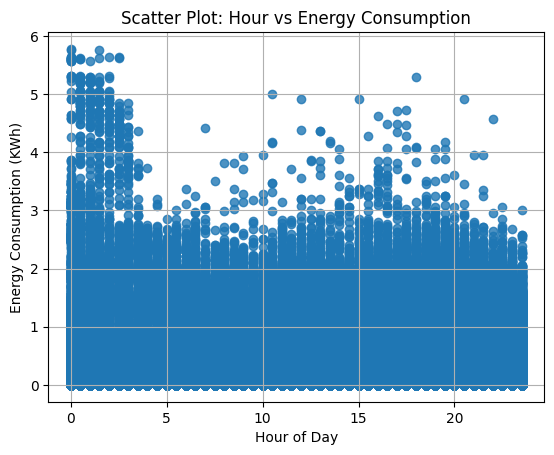

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df['hour'], df['Energy_consumed_per_half_hour'], alpha=0.8)
plt.title("Scatter Plot: Hour vs Energy Consumption")
plt.xlabel("Hour of Day")
plt.ylabel("Energy Consumption (KWh)")
plt.grid(True)
plt.show()

there is weekly positive relationship between time of day and energy consumption.

In [ ]:
# Perform ANOVA
# Group the data by time of day (in hours), which will allow us to compare energy consumption across time intervals
hour_groups = [group['Energy_consumed_per_half_hour'].values for _, group in df.groupby('hour')]

# Run the ANOVA test
stat, p_value = f_oneway(*hour_groups)

print(f"ANOVA F-statistic: {stat}")
print(f"p-value: {p_value}")

ANOVA F-statistic: 1142.5080339239894
p-value: 0.0


Conclusion :
- Reject the null hypothesis which mean There is a significant relationship between time of day and energy consumption

# Assuming that we can shutdown few cells were the consumption is low, what is the threshold that you would recommend ?

we can assume that the threshold by many ways.
- Use percentile to determine which values ​​are considered low (eg. 10th,25th).
- Consumption less than (mean - standard deviation) can be considered “low”.
- Certain times of the day that are naturally low in consumption (such as night hours) can be considered low.

 **1- percentile**
__________________________________

In [ ]:
# percentile as 10%.
threshold_10 = df['Energy_consumed_per_half_hour'].quantile(0.10)
# percentile as 25% "frist quantile".
threshold_25 = df['Energy_consumed_per_half_hour'].quantile(0.25)
print(f"Threshold 10th Percentile: {threshold_10:.2f} KWh")
print(f"Threshold 25th Percentile: {threshold_25:.2f} KWh")

Threshold 10th Percentile: 0.03 KWh
Threshold 25th Percentile: 0.07 KWh


**2- mean - standard deviation**
________________________________________

In [ ]:
mean = df['Energy_consumed_per_half_hour'].mean()
std_dev = df['Energy_consumed_per_half_hour'].std()
threshold_std = abs(mean - std_dev)
print(f"Threshold using Mean-Std: {threshold_std:.2f} KWh")

Threshold using Mean-Std: 0.07 KWh


**3- min. consuption during avg_day**
_______________________________________________

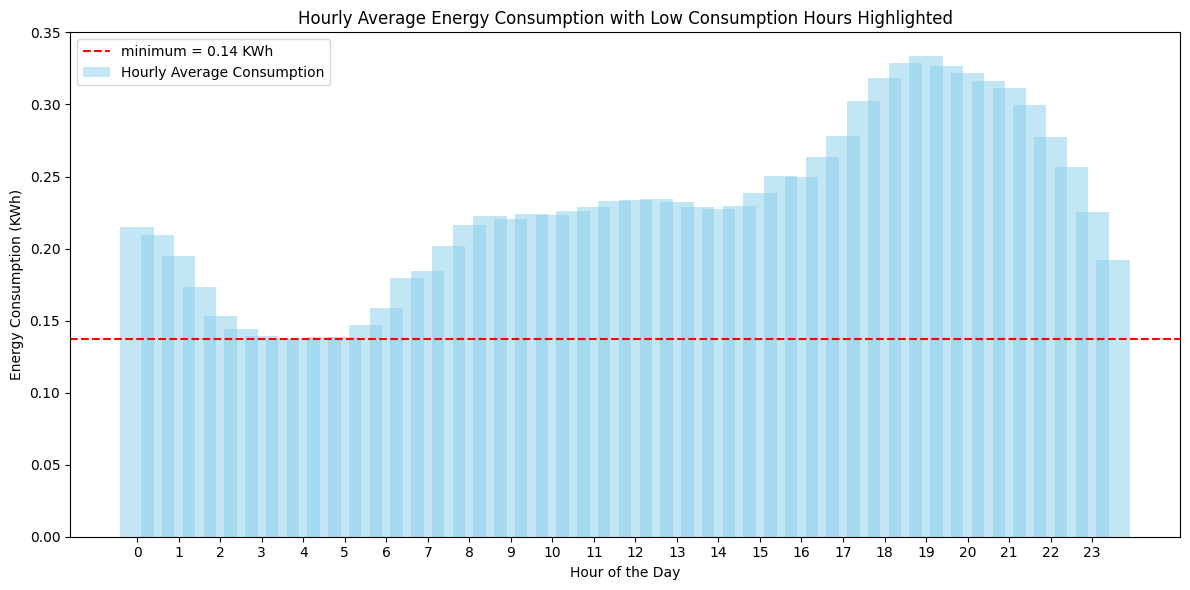

In [27]:
# Identify low consumption hours based on min
low_consumption_threshold = avg_energy_by_hour.min()
low_consumption_hours = avg_energy_by_hour[avg_energy_by_hour < low_consumption_threshold]

# Visualization
plt.figure(figsize=(12, 6))
plt.bar(avg_energy_by_hour.index, avg_energy_by_hour.values, color='skyblue', alpha=0.5, label='Hourly Average Consumption')
plt.axhline(y=low_consumption_threshold, color='r', linestyle='--', label=f'minimum = {low_consumption_threshold:.2f} KWh')

plt.title("Hourly Average Energy Consumption with Low Consumption Hours Highlighted")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (KWh)")
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# threshold according half hour
low_consumption_threshold = low_consumption_threshold/2
print(f"Threshold using Mean-Std: {low_consumption_threshold:.2f} KWh")

Threshold using Mean-Std: 0.07 KWh


so we can assume the the threshold = 0.07

In [29]:
# define new columns after Shutdown low consumed cells.
df['Energy_consumed_per_half_hour_threshold'] = np.where(df['Energy_consumed_per_half_hour'] < low_consumption_threshold, 0, df['Energy_consumed_per_half_hour'])

df['Cost_threshold'] = np.where(df['Energy_consumed_per_half_hour'] < low_consumption_threshold, 0, df['Cost_per_half_hour'])

# Check
df[['Energy_consumed_per_half_hour','Energy_consumed_per_half_hour_threshold','Cost_per_half_hour','Cost_threshold']].describe().round(2)

,Energy_consumed_per_half_hour,Energy_consumed_per_half_hour_threshold,Cost_per_half_hour,Cost_threshold
count,1379310.00,1379310.00,1379310.00,1379310.00
mean,0.23,0.22,0.05,0.05
std,0.30,0.30,0.08,0.08
min,0.00,0.00,0.00,0.00
25%,0.06,0.00,0.01,0.00
50%,0.14,0.14,0.03,0.02
75%,0.26,0.26,0.05,0.05
max,5.78,5.78,3.63,3.63


In [30]:
# how much KW and EGP it would saved ?
total_kwh = df['Energy_consumed_per_half_hour'].sum()
total_cost = df['Cost_per_half_hour'].sum()
total_kwh_saved = df['Energy_consumed_per_half_hour_threshold'].sum()
total_cost_saved = df['Cost_threshold'].sum()
print(f"Total KWh : {total_kwh:.2f} Total KWh Saved: {total_kwh_saved:.2f}")
print(f"which mean we save : {total_kwh-total_kwh_saved:.2f} kwh")
print(f"Total EGP : {total_cost:.2f} Total EGP Saved: {total_cost_saved:.2f}")
print(f"which mean we save : {total_cost-total_cost_saved:.2f} EGP")

Total KWh : 313982.56 Total KWh Saved: 300956.42
which mean we save : 13026.14 kwh
Total EGP : 66907.94 Total EGP Saved: 64246.21
which mean we save : 2661.73 EGP


In [36]:
# num of cell we shutdown after threshold
 (df['Energy_consumed_per_half_hour_threshold']==0).sum()

363539

# Dashboard

In [39]:
import dash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
import pandas as pd
import numpy as np
import plotly.express as px

# Initialize Dash App
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout
app.layout = dbc.Container([
    html.H1("Energy Costs Dashboard", style={"textAlign": "center"}),
    html.Hr(),

    dbc.Row([
        dbc.Col([
            html.Label("Select Region:"),
            dcc.Dropdown(
                id="region-dropdown",
                options=[{"label": r, "value": r} for r in df["region"].unique()],
                value="A",
                multi=False,
            )
        ], width=4),
        dbc.Col([
            html.Label("Select Demand Type:"),
            dcc.Dropdown(
                id="demand-dropdown",
                options=[{"label": d, "value": d} for d in df["Demand"].unique()],
                value="Normal",
                multi=False,
            )
        ], width=4)
    ]),
    html.Br(),

    dbc.Row([
        dbc.Col(dcc.Graph(id="consumption-bar-chart"), width=6),
        dbc.Col(dcc.Graph(id="cost-line-chart"), width=6)
    ])
])

# Callbacks
@app.callback(
    [Output("consumption-bar-chart", "figure"),
     Output("cost-line-chart", "figure")],
    [Input("region-dropdown", "value"),
     Input("demand-dropdown", "value")]
)
def update_charts(region, demand):
    filtered_data = df[(df["region"] == region) & (df["Demand"] == demand)].sort_values(by="DateTime")

    # Bar Chart: Hourly Energy Consumption
    hourly_data = filtered_data.groupby(filtered_data["DateTime"].dt.hour)["Energy_consumed_per_half_hour"].sum()
    bar_fig = px.bar(hourly_data, x=hourly_data.index, y=hourly_data.values, labels={"x": "Hour", "y": "Energy (KWh)"},
                     title="Hourly Energy Consumption")

    # Line Chart: Cost Over Time
    line_fig = px.line(filtered_data, x="DateTime", y="Cost_per_half_hour", title="Cost Over Time",
                       labels={"DateTime": "Time", "Cost_per_half_hour": "Cost (EGP)"})



    return bar_fig, line_fig

# Run App
if __name__ == "__main__":
    app.run_server(debug=True)


<IPython.core.display.Javascript object>